# Capturing the packets

To capture the packets it is needed to set the NIC in monitor mode. The instructions are [here](https://sandilands.info/sgordon/capturing-wifi-in-monitor-mode-with-iw)

The only special consideration is that you need to include the flag for capturing packets with the FCS fail:

```bash
sudo iw phy phy0 interface add mon0 type monitor flags fcsfail
```

# Analyzing the data

In [60]:
import pyshark
import pandas as pd
import matplotlib.pyplot as plt
# import binascii
import timeit

In [61]:
TOTAL_BITS = 400

In [62]:
# See the plots in Jupyter env
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load the captured packets

In [63]:
cap = pyshark.FileCapture('test_capture.pcapng')
# cap = pyshark.FileCapture('gvsp.pcapng')
# cap = pyshark.FileCapture('bigger test.pcapng')

### Filter the CRC broken packets

In [64]:
# Lets measure the time it takes to complete this
start_time = timeit.default_timer()
broken_pkts = [pkt for pkt in cap if pkt.wlan.fcs_bad == '1']
print ('Time taken: {}'.format(timeit.default_timer() - start_time))

total_broken_pkts = len(broken_pkts)

Time taken: 90.87238250899827


Get the broken data from the packets as a string, hex values and binary array <span style="color:red;">(Deprecated, it's done with Pandas now)</span> 

In [65]:
# # Broken data as a string
# broken_data = [pkt.data.data for pkt in broken_pkts]


# # filter out packets that have the wrong data length
# broken_data = [x for x in broken_data if len(x) == 100]
# total_broken_pkts_true_length = len(broken_data)
# total_broken_pkts_false_length = total_broken_pkts - total_broken_pkts_true_length

# # # Broken data as hex values
# # hex_broken_data=[]
# # count = 0
# # for data in broken_data:
# #     hex_broken_data.append([binascii.a2b_hex(data[byte:byte+2]) for byte in range(0, len(data),2)])
# #     #print(byte)
# #     count=count+1
    
# # Broken data as binary values
# def str2bin(number):
#     decimal_number = int(number,16)
#     # Do not return the '0b' at the beginning and fill with zeroes
#     return bin(decimal_number)[2:].zfill(8)
# bin_broken_data = []
# for data in broken_data:
#     bin_broken_data.append([str2bin(data[byte : byte+2]) for byte in range(0, len(data),2)])




Build a single array of bits per broken data  <span style="color:red;">(Deprecated, it's done with Pandas now)</span> 

In [66]:
# temp = []
# temp_str = ''
# for data in bin_broken_data:
#     for byte in data:
#         temp_str = temp_str + byte
#     temp.append(temp_str)
#     temp_str=''

# bin_broken_data = temp
    

Or using pandas, we build the data frame with some usefull columns:

In [67]:
# Broken data as a string
p_data = pd.DataFrame([pkt.data.data for pkt in broken_pkts], columns=['Data'])

# Add a column stating if the data has the right length
p_data['Right_Length'] = p_data['Data'].apply(lambda x: len(x) == 100)

# Add a column with Binary Data
def str2bin(number):
    decimal_number = int(number,16)
    # Do not return the '0b' at the beginning and fill with zeroes
    return bin(decimal_number)[2:].zfill(8)

def data_to_bin(data):
    return [str2bin(data[byte : byte+2]) for byte in range(0, len(data),2)]

def bytes_to_binarray(list_of_bytes):
    temp_str = ''
    for byte in list_of_bytes:
        temp_str = temp_str + byte
    return temp_str

p_data['Data_bin'] = p_data['Data'].apply(data_to_bin)
p_data['Data_bin'] = p_data['Data_bin'].apply(bytes_to_binarray)

# Add column with number of bits flipped
p_data['Flipped_bits'] = p_data['Data_bin'].apply(lambda x: x.count('1'))

Count the number of packets with the right and wrong length

In [68]:
# Group the packets in right/wrong length and count the number of occurences
lengths = p_data.groupby(['Right_Length']).size()

# Right length
total_broken_pkts_true_length = lengths[True]

# Wrong length
total_broken_pkts_false_length = lengths[False]

Create a vector containing the number of bits flipped in specific locations

In [69]:
# Empty vector
flips_occurences = [0]*TOTAL_BITS

# Operate only over data packets of the right size
right_size_data = p_data[p_data['Right_Length'] == True]['Data_bin']

for row in right_size_data:
    # Traverse the vector
    for i,x in enumerate(row):
        # If the value is a '1' add one to the vector of flips_occurences
        if x == '1':
            flips_occurences[i] = flips_occurences[i] + 1

Plot the histogram with flip ocurrences

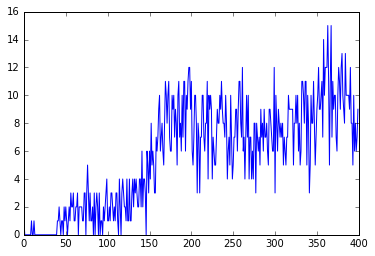

In [70]:
fig = plt.figure()
plt.plot(range(len(flips_occurences)),flips_occurences)

# =========================================================
### Cells for testing code
# =========================================================

In [71]:
len(broken_pkts)

84

In [44]:
# cap2 = pyshark.FileCapture('big test.pcapng',display_filter='wlan.fcs_bad == true')
cap2 = pyshark.FileCapture('test_capture.pcapng',display_filter='udp')

In [56]:
for pkt in broken_pkts:
    print (pkt)

Packet (Length: 150)
Layer RADIOTAP:
	.... .... ...0 .... = Turbo: False
	.... .... .... .... ...0 .... .... .... = dB Antenna Signal: Absent
	.... .... .... .... .... .... 0... .... = Lock Quality: Absent
	Present flags
	...1 .... = FCS at end: True
	.... .... .... .... .... ...0 .... .... = TX Attenuation: Absent
	.... .... .... .... .... ..0. .... .... = dB TX Attenuation: Absent
	.... .... .... .... .... 0... .... .... = Antenna: Absent
	.... .... .... .... .... .... .... ...1 = TSFT: Present
	.... ...0 = CFP: False
	.... .... ...0 .... .... .... .... .... = A-MPDU Status: Absent
	RX flags: 0x0000
	.... ...0 .... .... = 5 GHz spectrum: False
	.... .... .... .... .1.. .... .... .... = RX flags: Present
	.... .... .... .... .... .... ...0 .... = FHSS: Absent
	Header pad: 0
	.... .... .... .0.. .... .... .... .... = Channel+: Absent
	.0.. .... .... .... = Half Rate Channel (10MHz Channel Width): False
	Channel frequency: 2437 [BG 6]
	..1. .... .... .... .... .... .... .... = Radiotap 

range(0, 3)
